In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import time


In [2]:
class NeuralNet(nn.Module):
    def __init__(self, h1, h2=0, in_features=2):
        super().__init__()
        self.h1 = h1
        self.h2 = h2
        self.hn1 = nn.Linear(in_features, h1)
        if h2 > 0:
            self.hn2 = nn.Linear(h1, h2)
            self.out = nn.Linear(h2, 1)
        else:
            self.out = nn.Linear(h1, 1)
        
    def forward(self, X):
        X = torch.tanh(self.hn1(X))
        if self.h2 > 0:
            X = torch.tanh(self.hn2(X))
            X = torch.sigmoid(self.out(X))
        else:
            X = torch.sigmoid(self.out(X))
        return X


In [3]:
def get_labels(X, case=1):
    y = []
    
    # case=1 is big squares (balanced data)
    if case == 1:
        for data in X:
            x1, x2 = data
            if ((-4 <= x1 <= -1) and (0 <= x2 <= 3)) or ((-2 <= x1 <= 1) and (-4 <= x2 <= -1)) or ((2 <= x1 <= 5) and (-2 <= x2 <= 1)):
                y.append(1)
            else:
                y.append(0)
    # case=2 is small squares (imbalanced data)
    elif case == 2:
        for data in X:
            x1, x2 = data
            if ((-4 <= x1 <= -3) and (2 <= x2 <= 3)) or ((-1 <= x1 <= 0) and (-2 <= x2 <= -1)) or ((2 <= x1 <= 3) and (-1 <= x2 <= 0)):
                y.append(1)
            else:
                y.append(0)
    else:
        raise ValueError("Invalid value for case is specified. Enter either 1 or 2!")

    return np.array(y)


In [4]:
def testing(model, X_test, y_test, X_graph1, X_graph2, threshold=0.5, test=False):
    with torch.no_grad():
        y_pred_test_soft = []
        y_pred_test = []
        for i, data in enumerate(X_test):
            y_out = model.forward(data)
            y_pred_test_soft.append(y_out)
            # convert soft probabilities to classes
            if y_out < threshold:
                y_pred_test.append(0)
                X_graph1.append(data.numpy())
            else:
                y_pred_test.append(1)
                X_graph2.append(data.numpy())
        y_pred_test_soft = torch.FloatTensor(y_pred_test_soft)
        y_pred_test = torch.FloatTensor(y_pred_test)

        acc_score = accuracy_score(y_test, y_pred_test)
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_test)
        if test:
            print(metrics.confusion_matrix(y_test, y_pred_test))
        if len(np.unique(y_test)) == 1:
            auc = np.NAN
        else:
            auc = metrics.roc_auc_score(y_test, y_pred_test_soft)
        return [bal_acc_score, acc_score, auc]


In [5]:
step = 0.1
X_fine1 = np.arange(-6, 6, step)
X_fine2 = np.arange(-4, 4, step)
m, n = len(X_fine1), len(X_fine2)
X_fine = []
[[X_fine.append([X_fine1[i], X_fine2[j]]) for i in range(m)] for j in range(n)]
X_fine = np.array(X_fine)
y_fine = {}

# case == 1 (balanced data)
y_fine[1] = get_labels(X_fine, 1)
y_fine[1] = y_fine[1].reshape(y_fine[1].shape[0], 1)
# case == 2 (imbalanced data)
y_fine[2] = get_labels(X_fine, 2)
y_fine[2] = y_fine[2].reshape(y_fine[2].shape[0], 1)

X_fine = torch.FloatTensor(X_fine)
y_fine[1] = torch.FloatTensor(y_fine[1])
y_fine[12] = torch.FloatTensor(y_fine[2])

print(X_fine.shape)


torch.Size([9600, 2])


In [6]:
def get_metrics(X, n, h1, h2, is_fine=False, case=1, threshold=0.5, lr=0.001, epochs=1000, splits=5, test=False):
    model = NeuralNet(h1, h2)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    kf = StratifiedKFold(n_splits=splits)
    results = []

    X_graph1, X_graph2, gph_cnt1, gph_cnt2 = [], [], [], []
    y = get_labels(X, case)
    
    index = 0
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_all = np.append(y_train, y_test)
        if len(np.unique(y_train)) == 1:
            continue
        y_train, y_test = y_train.reshape((y_train.shape[0], 1)), y_test.reshape((y_test.shape[0], 1))
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)
        for epoch in range(epochs):
            y_pred = model(X_train)
            optimizer.zero_grad()
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        if not is_fine:
            results.append(testing(model, X_test, y_test, X_graph1, X_graph2, threshold, test))
        else:
            results.append(testing(model, X_fine, y_fine[case], X_graph1, X_graph2, threshold, test))

        gph_cnt1.append(len(X_graph1))
        gph_cnt2.append(len(X_graph2))


    output = np.array(results).mean(axis=0)
    return (output, np.array(X_graph1), np.array(X_graph2), np.array(gph_cnt1), np.array(gph_cnt2))


[  0  50 100 150 200 250]
[0 0 0 0 0 0]
[  0  50 100 150 200 250]
[0 0 0 0 0 0]


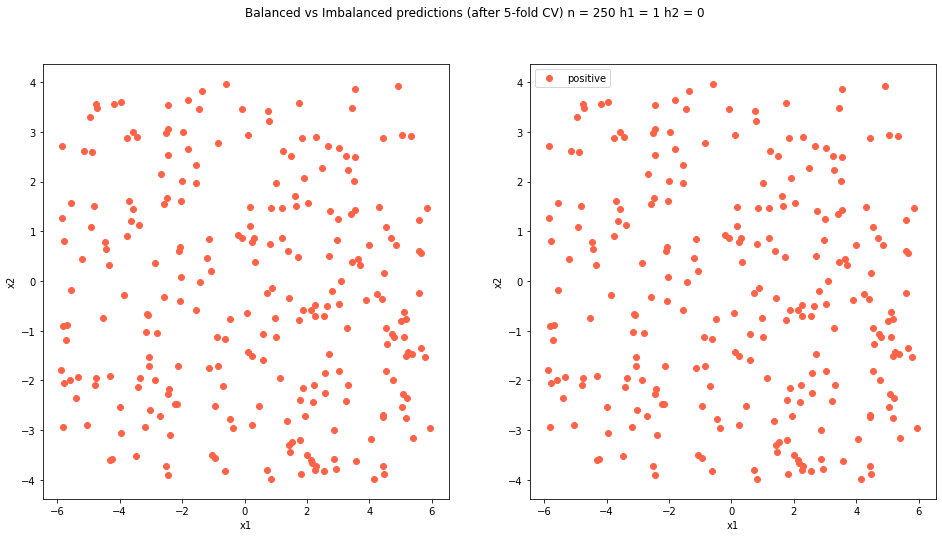

[    0  5092 14692 24292 33892 43492]
[   0 4508 4508 4508 4508 4508]


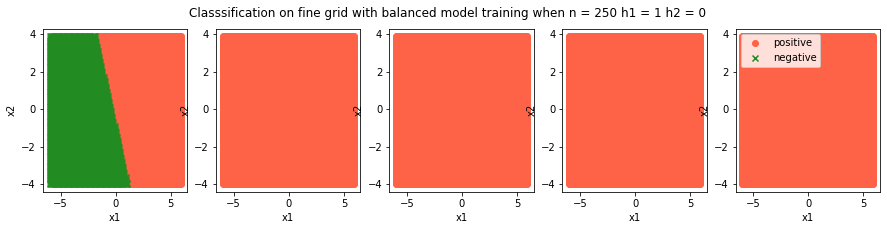

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


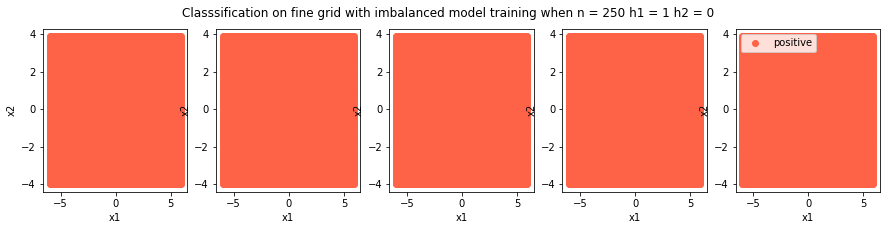

[  0  50 100 150 200 250]
[0 0 0 0 0 0]
[  0  50 100 150 200 250]
[0 0 0 0 0 0]


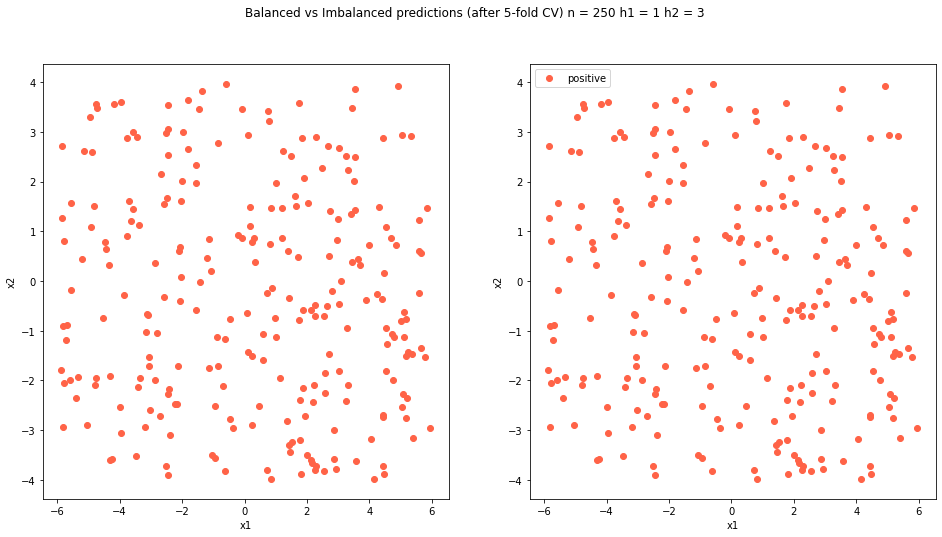

[    0  9600 19200 28800 36894 44782]
[   0    0    0    0 1506 3218]


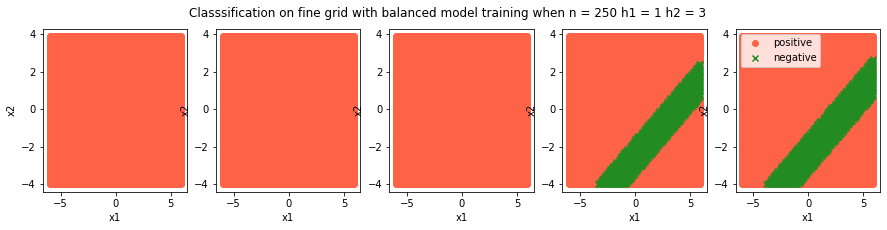

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


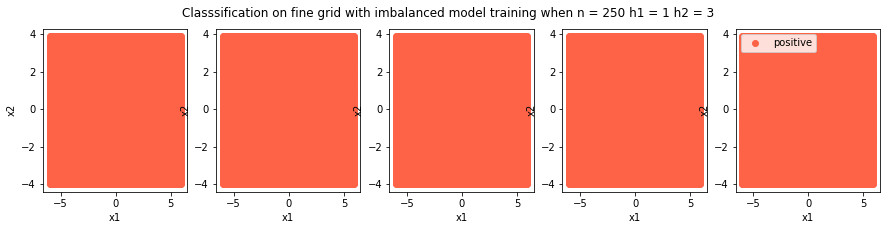

[  0  50  91 133 171 212]
[ 0  0  9 17 29 38]
[  0  50 100 150 200 250]
[0 0 0 0 0 0]


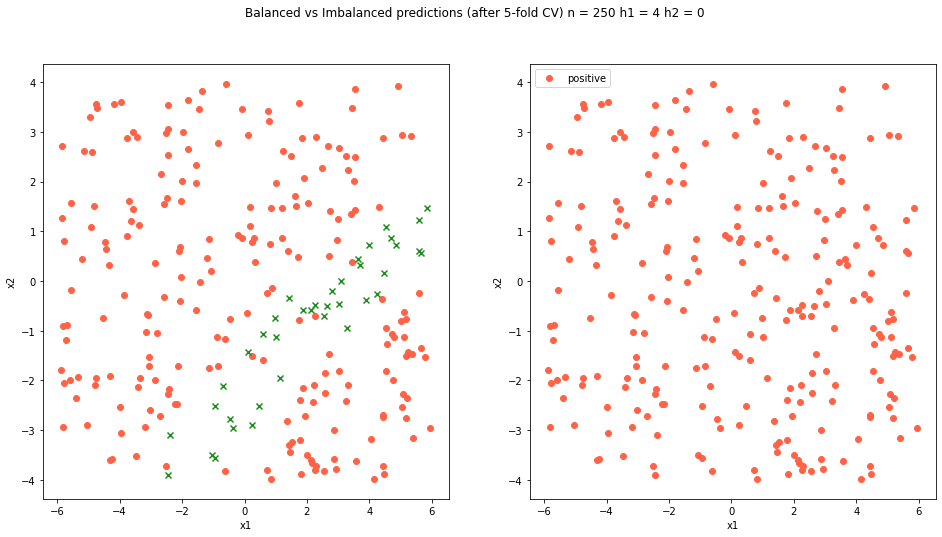

[    0  7605 14022 20064 26080 32217]
[    0  1995  5178  8736 12320 15783]


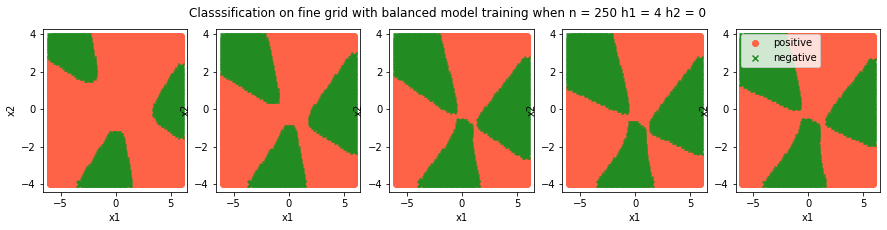

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


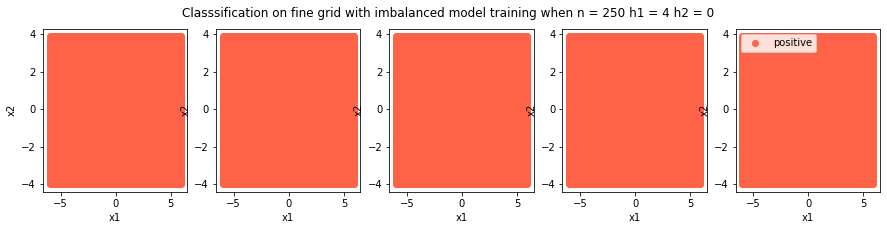

[  0  41  83 118 147 187]
[ 0  9 17 32 53 63]
[  0  50 100 150 199 246]
[0 0 0 0 1 4]


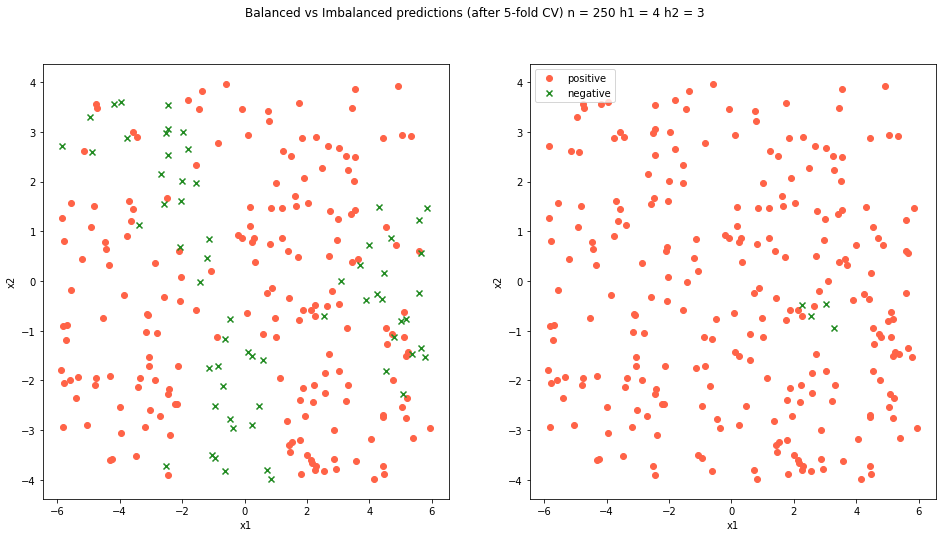

[    0  8313 16041 23335 29738 36491]
[    0  1287  3159  5465  8662 11509]


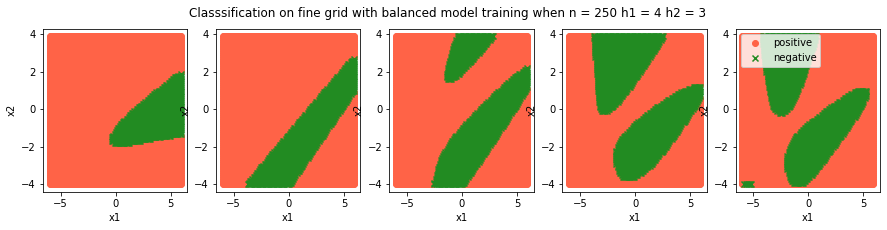

[    0  9600 19200 28637 38082 47437]
[  0   0   0 163 318 563]


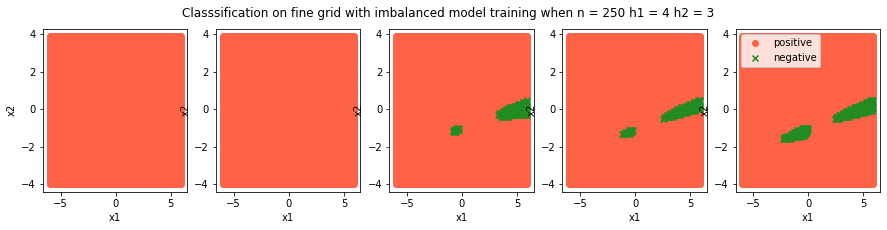

[  0  32  66  99 129 165]
[ 0 18 34 51 71 85]
[  0  50 100 150 198 244]
[0 0 0 0 2 6]


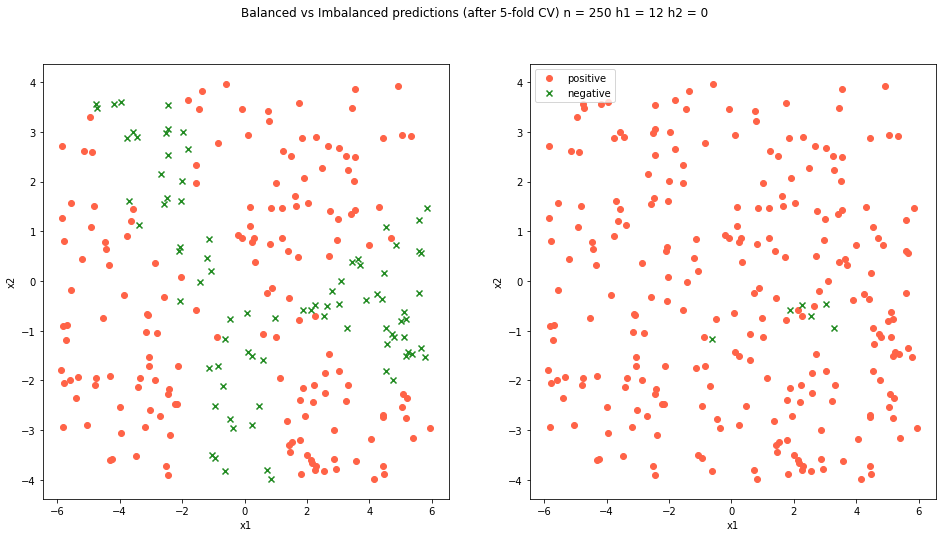

[    0  6629 13463 20048 26616 33605]
[    0  2971  5737  8752 11784 14395]


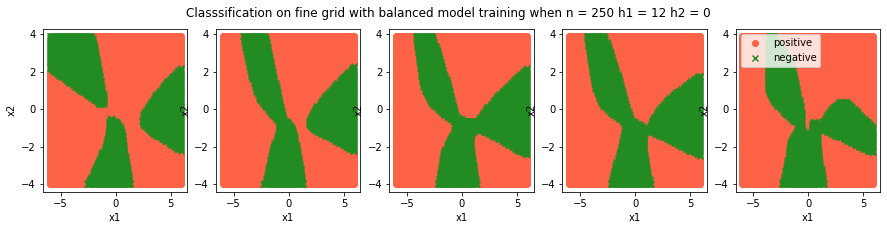

[    0  9600 19200 28800 38379 47870]
[  0   0   0   0  21 130]


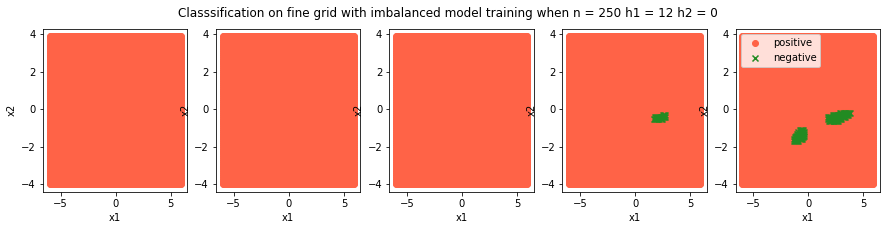

[  0  28  63  99 136 173]
[ 0 22 37 51 64 77]
[  0  50 100 148 195 241]
[0 0 0 2 5 9]


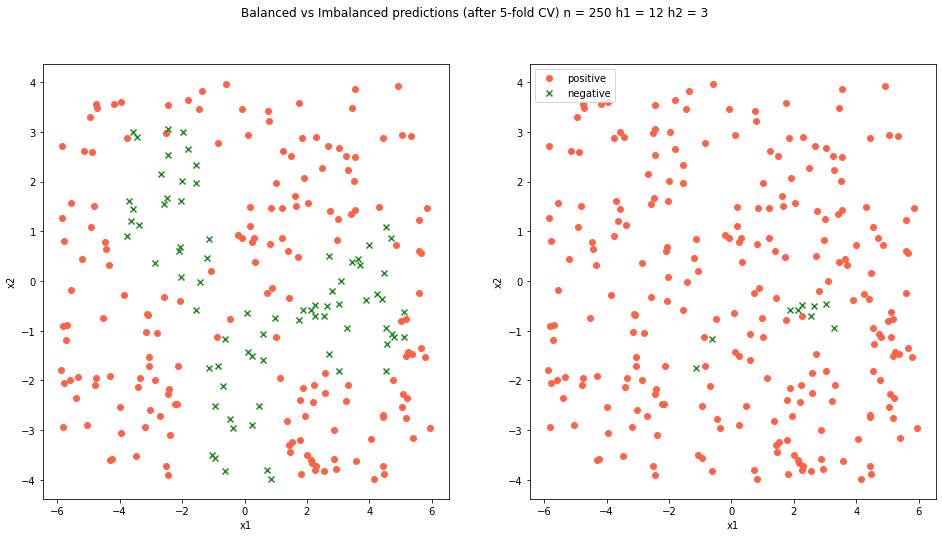

[    0  6698 13729 20746 27795 34732]
[    0  2902  5471  8054 10605 13268]


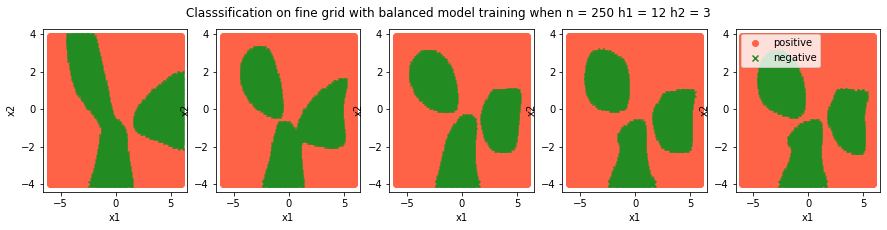

[    0  9600 19178 28707 38126 47497]
[  0   0  22  93 274 503]


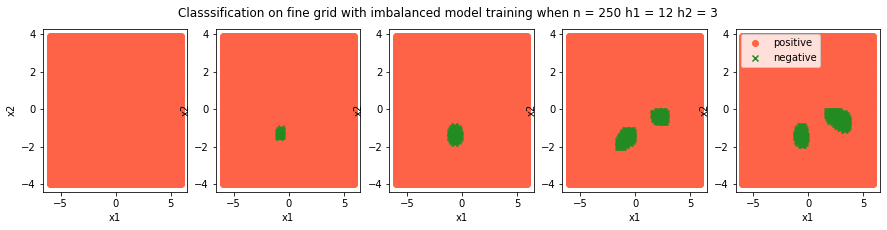

[   0  200  400  600  800 1000]
[0 0 0 0 0 0]
[   0  200  400  600  800 1000]
[0 0 0 0 0 0]


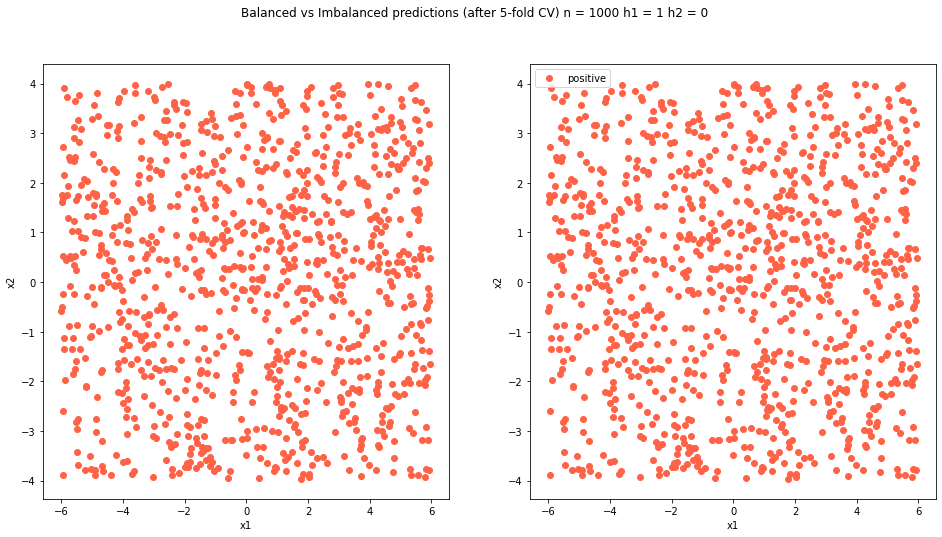

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


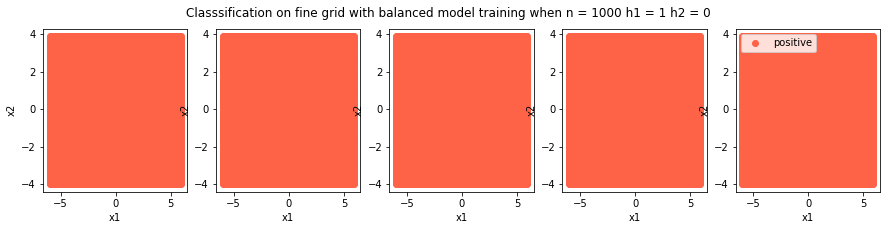

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


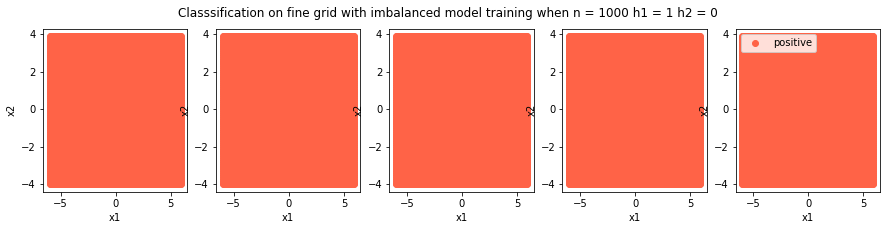

[   0  200  400  600  800 1000]
[0 0 0 0 0 0]
[   0  200  400  600  800 1000]
[0 0 0 0 0 0]


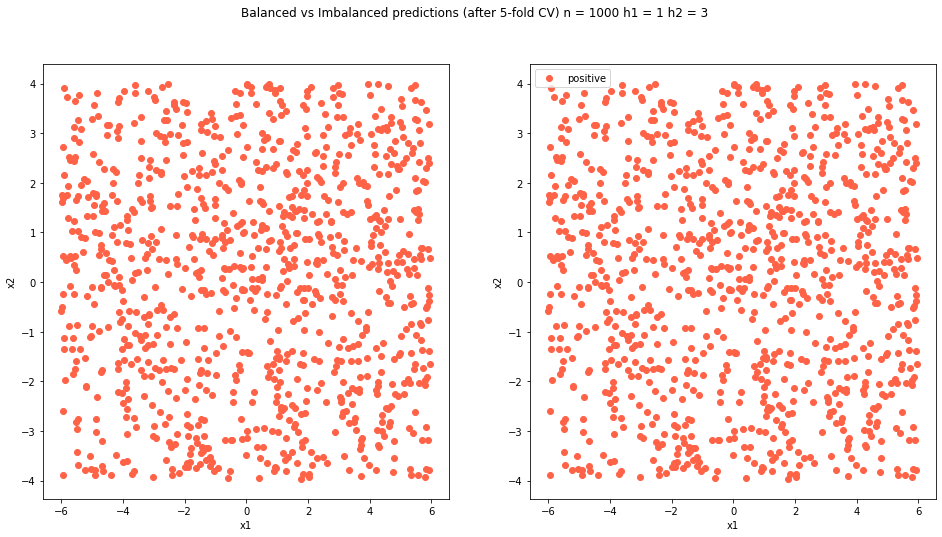

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


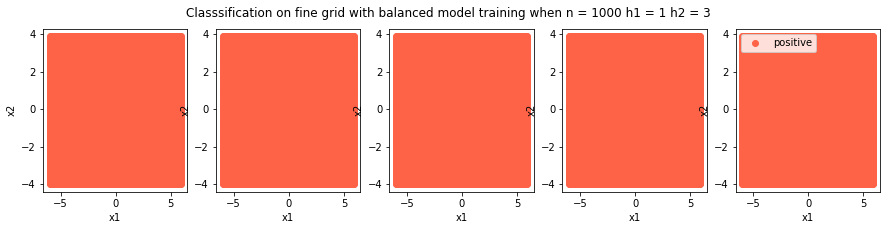

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


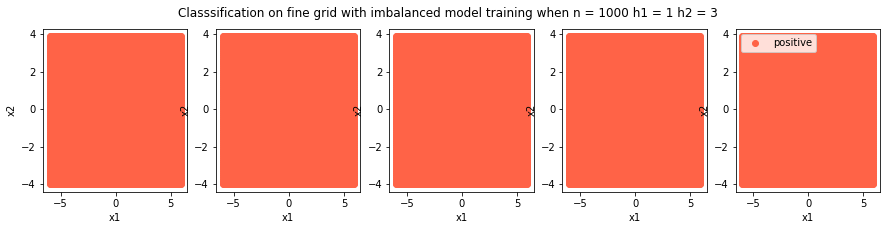

[  0 170 331 500 684 864]
[  0  30  69 100 116 136]
[   0  200  400  600  800 1000]
[0 0 0 0 0 0]


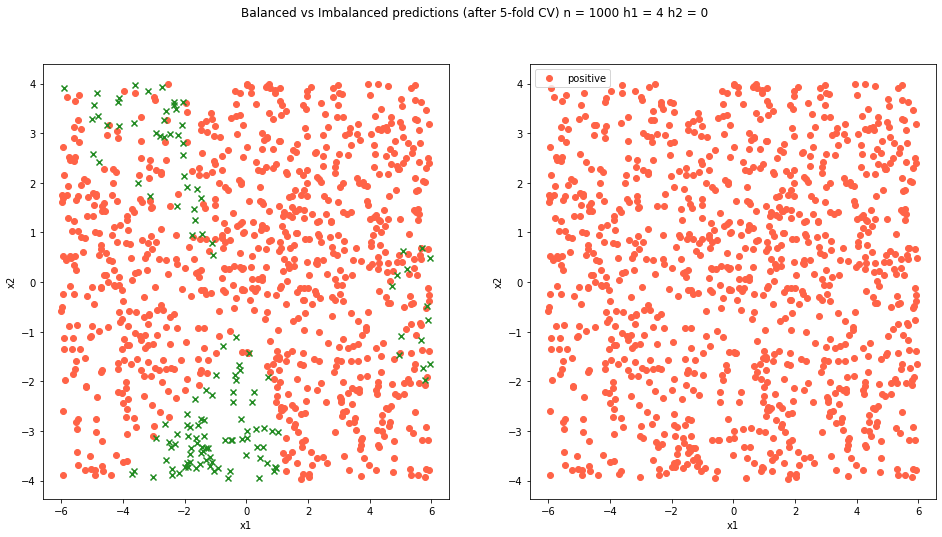

[    0  9010 17748 25738 34378 42914]
[   0  590 1452 3062 4022 5086]


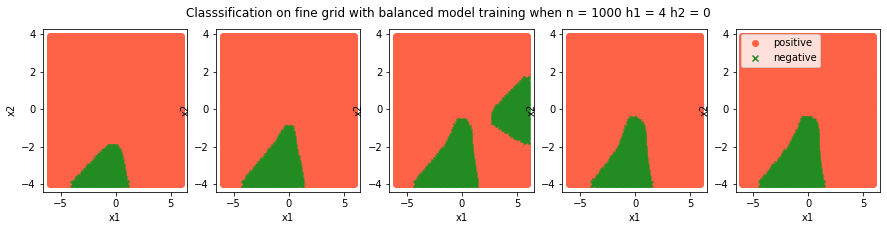

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


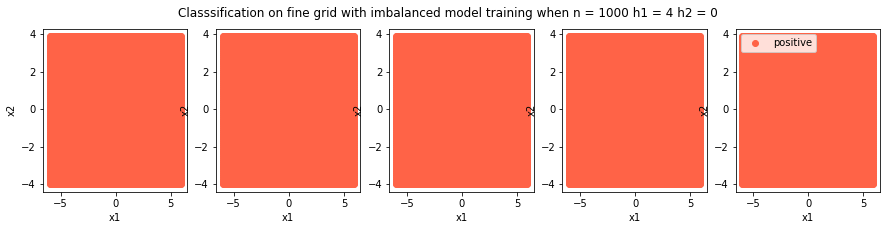

[  0 179 346 492 640 786]
[  0  21  54 108 160 214]
[   0  200  400  600  800 1000]
[0 0 0 0 0 0]


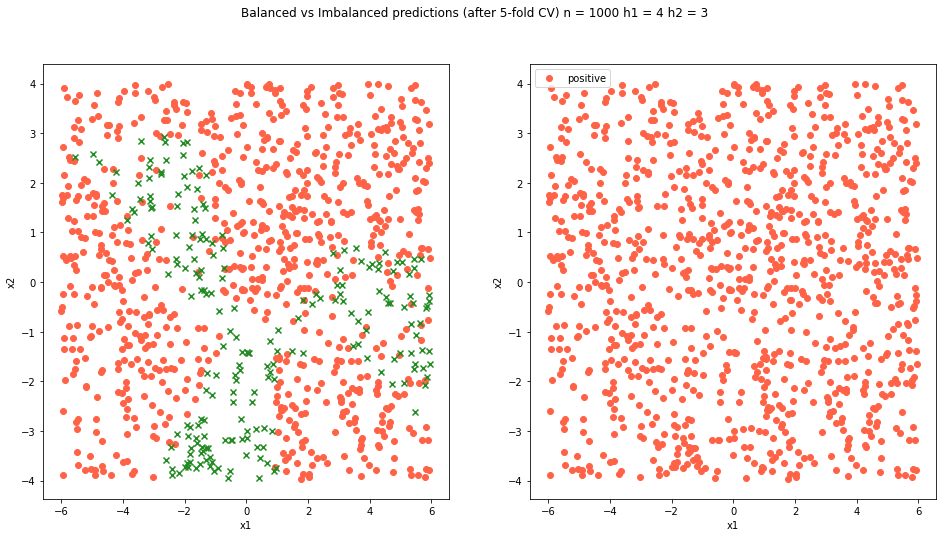

[    0  8185 15922 23620 31456 39369]
[   0 1415 3278 5180 6944 8631]


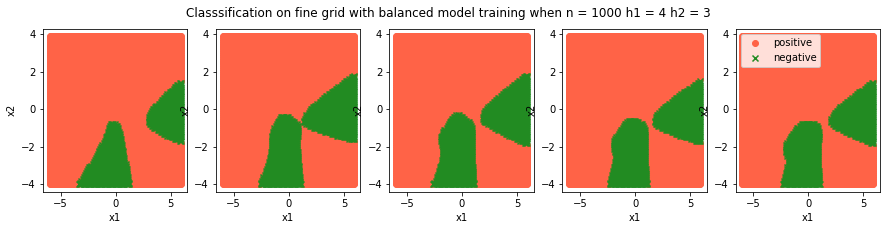

[    0  9600 19200 28800 38395 47893]
[  0   0   0   0   5 107]


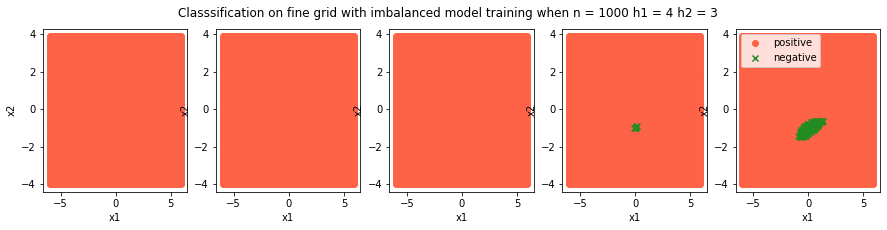

[  0 178 342 489 633 790]
[  0  22  58 111 167 210]
[   0  200  400  600  800 1000]
[0 0 0 0 0 0]


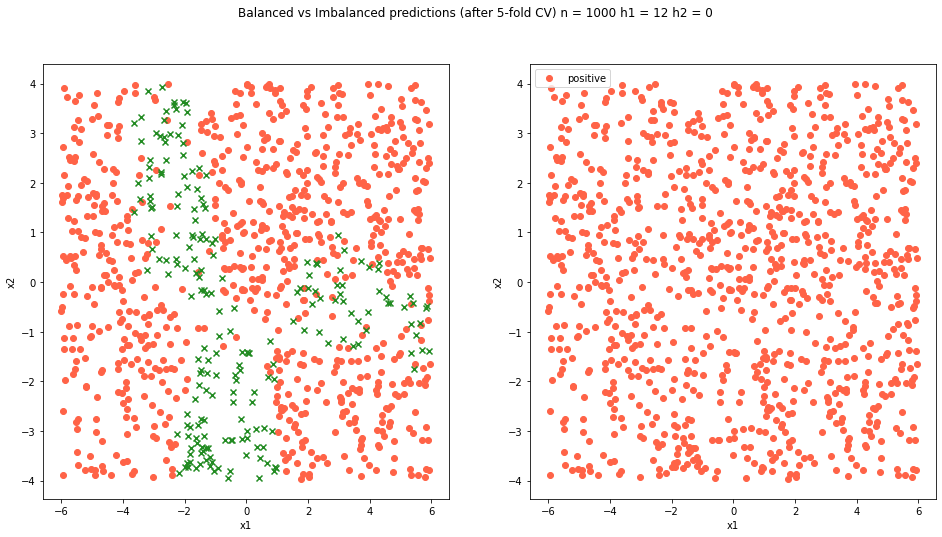

[    0  8789 17509 25588 33574 41006]
[   0  811 1691 3212 4826 6994]


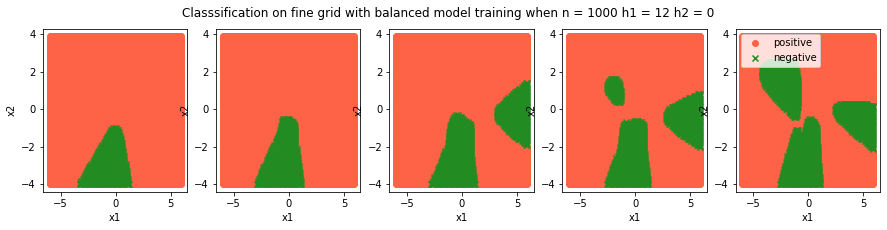

[    0  9600 19200 28800 38400 47994]
[0 0 0 0 0 6]


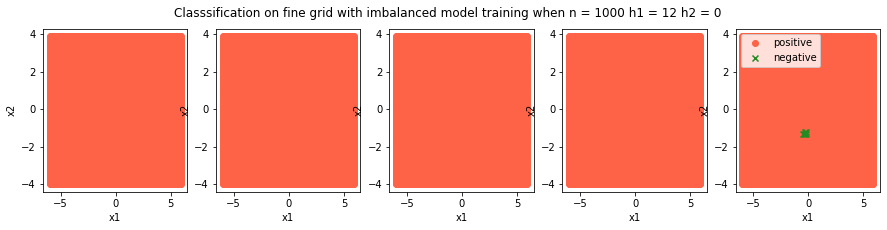

[  0 152 297 446 592 739]
[  0  48 103 154 208 261]
[   0  200  400  600  800 1000]
[0 0 0 0 0 0]


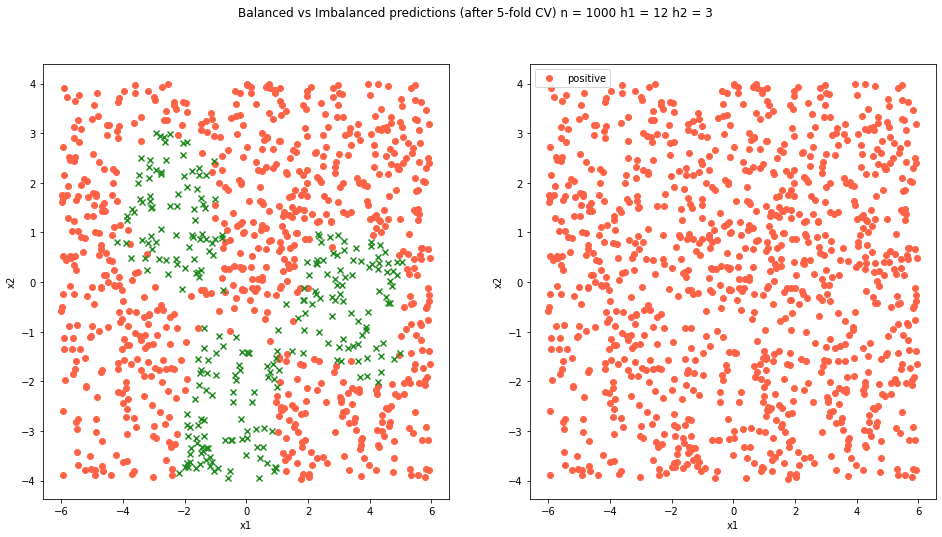

[    0  8246 15281 22273 29240 36191]
[    0  1354  3919  6527  9160 11809]


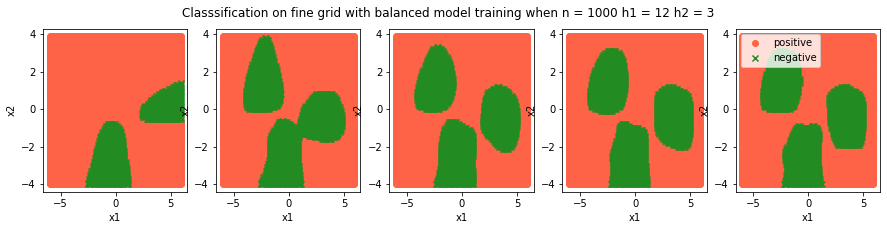

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


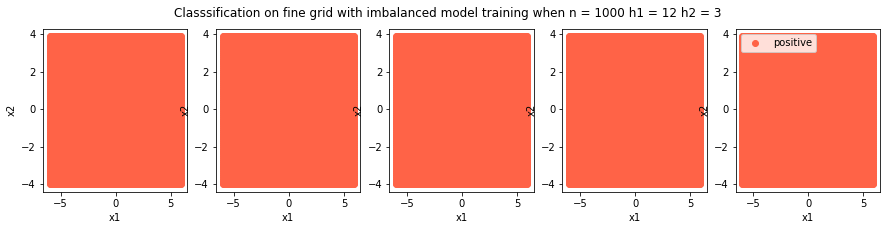

[    0  2000  4000  6000  8000 10000]
[0 0 0 0 0 0]
[    0  2000  4000  6000  8000 10000]
[0 0 0 0 0 0]


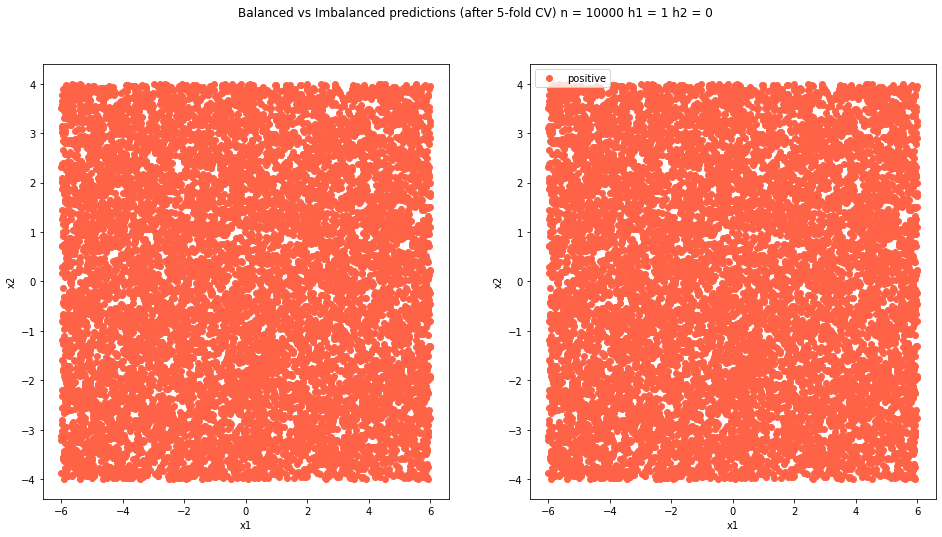

[    0  5760 15360 24960 34560 44160]
[   0 3840 3840 3840 3840 3840]


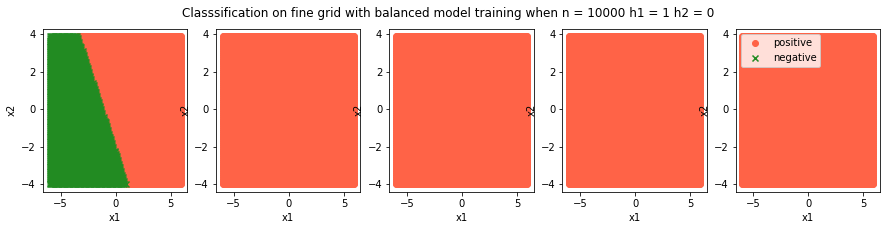

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


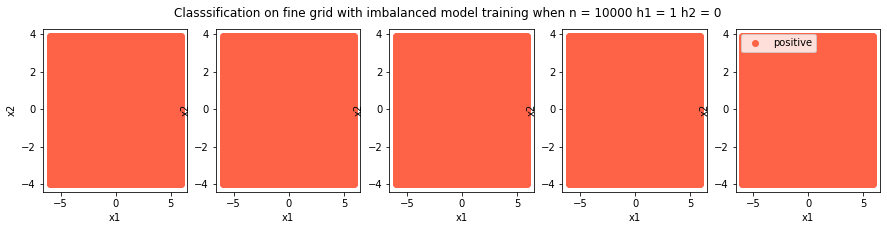

[   0 2000 4000 6000 7681 9292]
[  0   0   0   0 319 708]
[    0  2000  4000  6000  8000 10000]
[0 0 0 0 0 0]


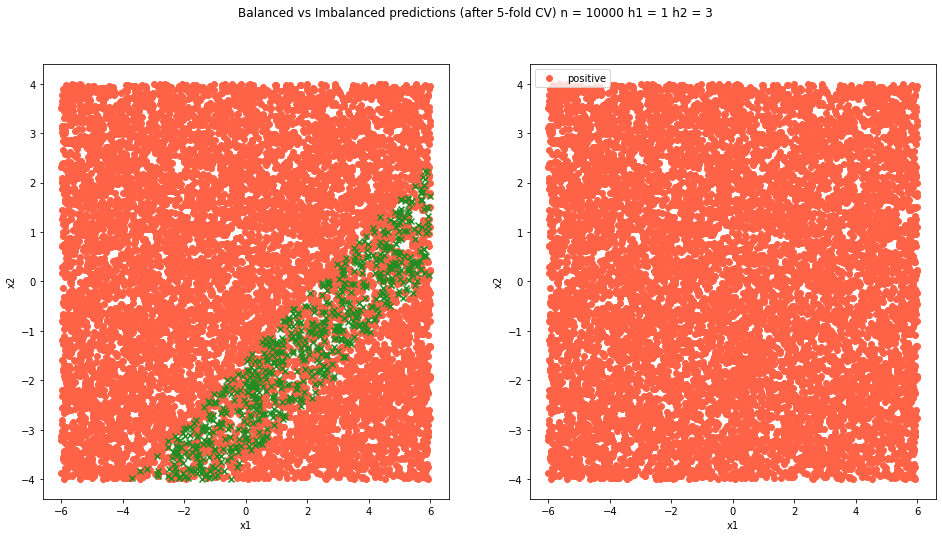

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


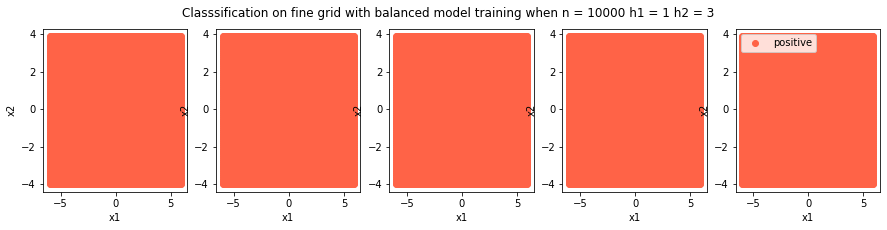

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


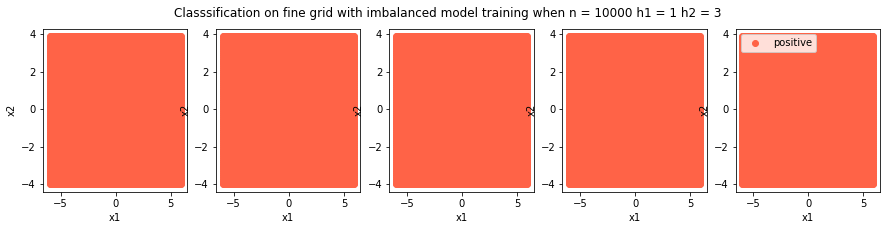

[   0 2000 3791 5451 7130 8817]
[   0    0  209  549  870 1183]
[    0  2000  4000  6000  8000 10000]
[0 0 0 0 0 0]


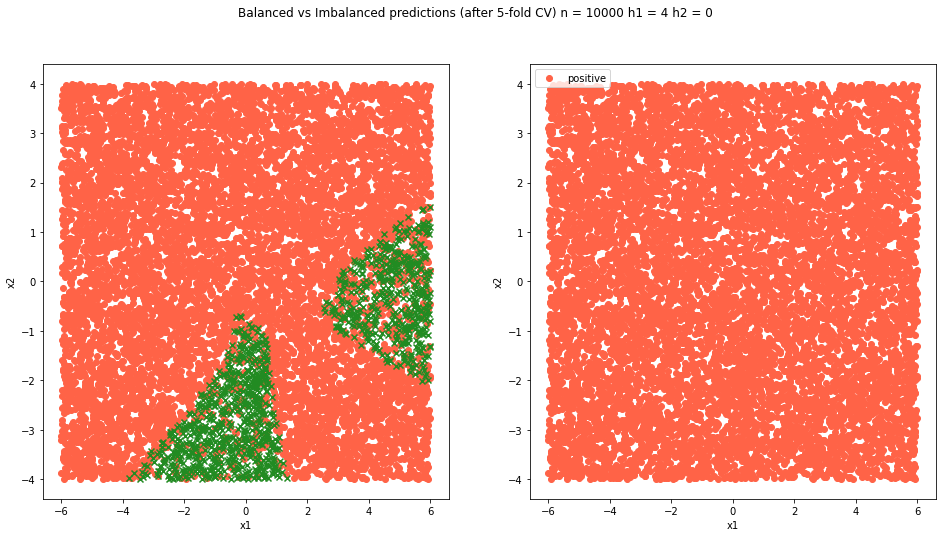

[    0  9600 18044 25857 33531 41129]
[   0    0 1156 2943 4869 6871]


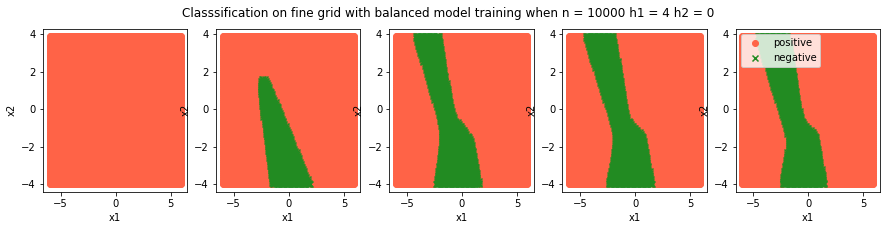

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


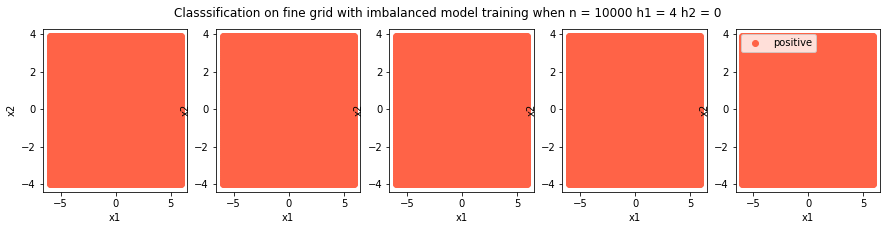

[   0 1630 3147 4602 6058 7543]
[   0  370  853 1398 1942 2457]
[    0  2000  4000  6000  8000 10000]
[0 0 0 0 0 0]


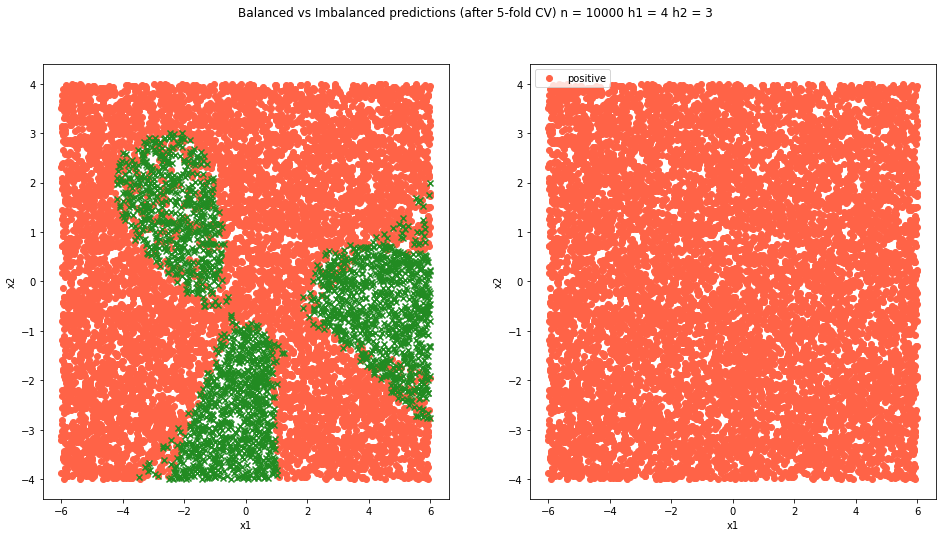

[    0  8748 17528 26288 33290 39837]
[   0  852 1672 2512 5110 8163]


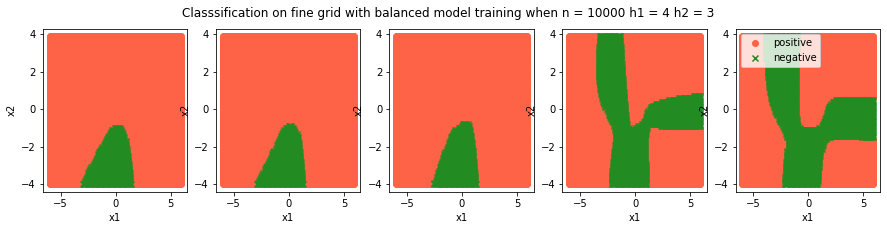

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


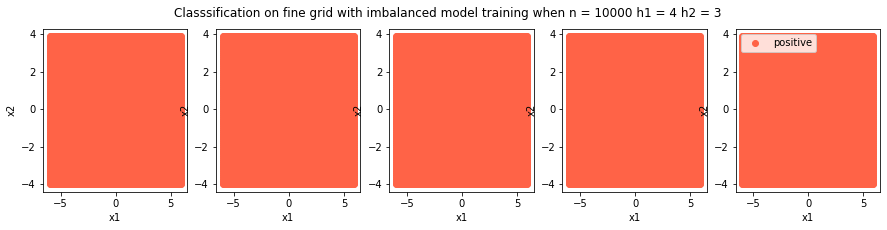

[   0 1686 3327 4771 6221 7636]
[   0  314  673 1229 1779 2364]
[    0  2000  4000  6000  8000 10000]
[0 0 0 0 0 0]


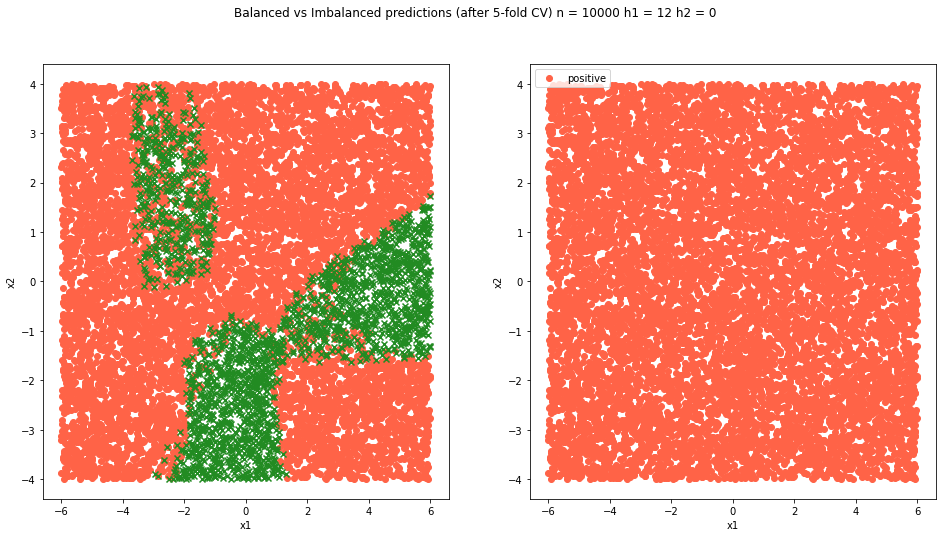

[    0  7844 14939 21874 28750 35664]
[    0  1756  4261  6926  9650 12336]


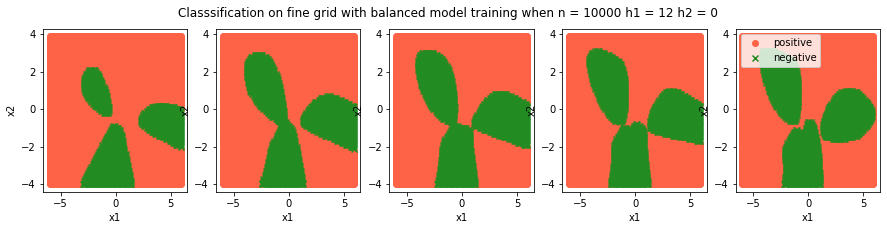

[    0  9600 19200 28800 38400 48000]
[0 0 0 0 0 0]


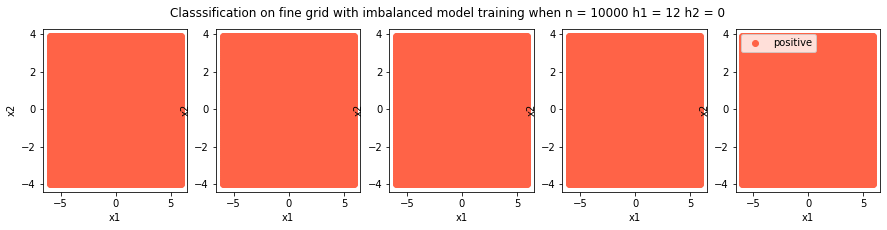

[   0 1502 2967 4423 5890 7353]
[   0  498 1033 1577 2110 2647]
[   0 2000 4000 6000 7997 9971]
[ 0  0  0  0  3 29]


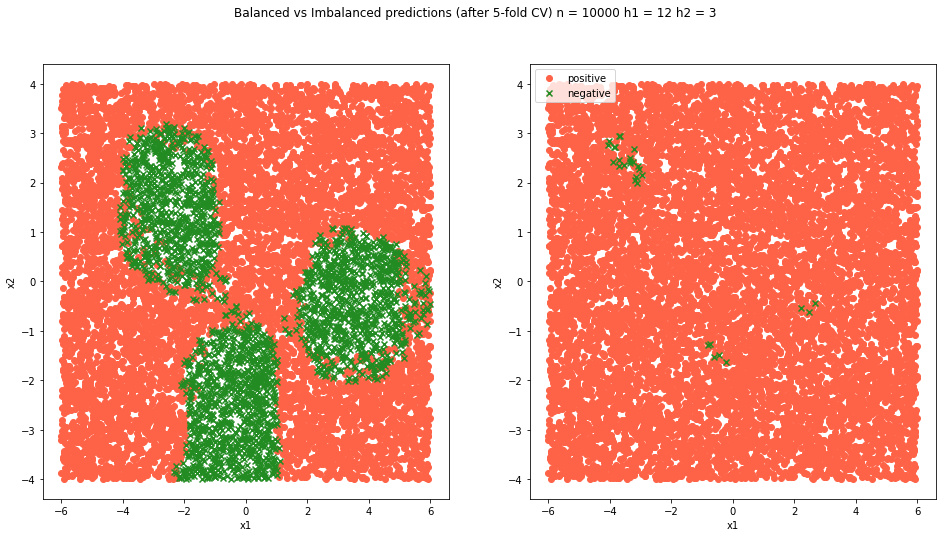

[    0  7137 14103 21020 27914 34810]
[    0  2463  5097  7780 10486 13190]


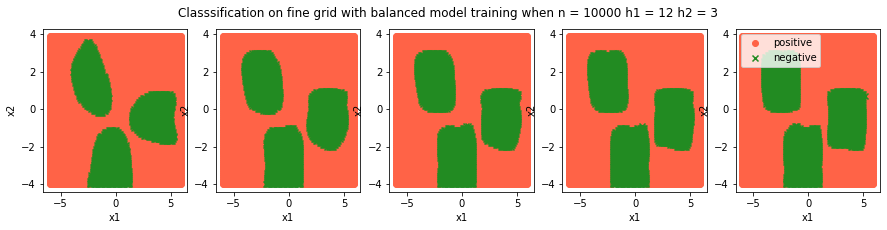

[    0  9600 19200 28800 38312 47704]
[  0   0   0   0  88 296]


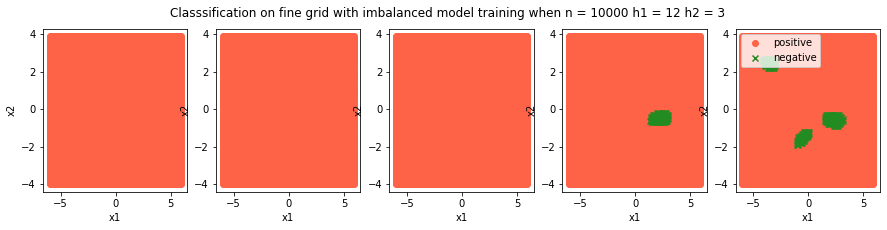

n	h1	h2	Balanced Accuracy	Balanced Accuracy	Balanced Accuracy	Balanced Accuracy	Classification Accuracy	Classification Accuracy	Classification Accuracy	Classification Accuracy	Area Under the ROC Curve	Area Under the ROC Curve	Area Under the ROC Curve	Area Under the ROC Curve
n	h1	h2	Uniform	Uniform	Fine	Fine	Uniform	Uniform	Fine	Fine	Uniform	Uniform	Fine	Fine
n	h1	h2	Case A	Case B	Case A	Case B	Case A	Case B	Case A	Case B	Case A	Case B	Case A	Case B
250	1	0	0.5	0.5	0.5168	0.5	0.704	0.956	0.6912	0.9688	0.5387	0.3909	0.4907	0.5204	
250	1	3	0.5	0.5	0.56	0.5	0.704	0.956	0.738	0.9688	0.5125	0.4101	0.6955	0.4988	
250	4	0	0.6521	0.5	0.7398	0.5	0.768	0.956	0.7688	0.9688	0.7461	0.4007	0.8521	0.6756	
250	4	3	0.7144	0.5791	0.6998	0.5232	0.78	0.956	0.7754	0.9606	0.8532	0.725	0.8239	0.8251	
250	12	0	0.7956	0.6103	0.8121	0.5275	0.812	0.956	0.8399	0.9695	0.9134	0.9221	0.9142	0.8865	
250	12	3	0.9048	0.7082	0.888	0.6071	0.916	0.96	0.9116	0.9719	0.9774	0.9201	0.9608	0.9258	
1000	1	0	0.5	0.5	0.5	0.5	0.73

In [7]:
fig_num = 1
print_output = []
print_output.append(f"n\th1\th2\tBalanced Accuracy\tBalanced Accuracy\tBalanced Accuracy\tBalanced Accuracy\tClassification Accuracy\tClassification Accuracy\tClassification Accuracy\tClassification Accuracy\tArea Under the ROC Curve\tArea Under the ROC Curve\tArea Under the ROC Curve\tArea Under the ROC Curve\n")

print_output.append(f"n\th1\th2\tUniform\tUniform\tFine\tFine\tUniform\tUniform\tFine\tFine\tUniform\tUniform\tFine\tFine\n")

print_output.append(f"n\th1\th2\tCase A\tCase B\tCase A\tCase B\tCase A\tCase B\tCase A\tCase B\tCase A\tCase B\tCase A\tCase B\n")


for n in [250, 1000, 10000]:
    X = np.random.uniform(low=[-6, -4], high=[6, 4], size=(n, 2))
    for h1 in [1, 4, 12]:
        for h2 in [0, 3]:
#             print(f"n = {n} h1 = {h1} h2 = {h2}")
            sub_output = []
            
            metrics_and_graphs_1 = get_metrics(X, n, h1, h2, False, 1, 0.5, 0.001, 1000, 5, False)
            sub_output.append(metrics_and_graphs_1[0])
            metrics_and_graphs_2 = get_metrics(X, n, h1, h2, False, 2, 0.5, 0.001, 1000, 5, False)
            sub_output.append(metrics_and_graphs_2[0])
            metrics_and_graphs_3 = get_metrics(X, n, h1, h2, True, 1, 0.5, 0.001, 1000, 5, False)
            sub_output.append(metrics_and_graphs_3[0])
            metrics_and_graphs_4 = get_metrics(X, n, h1, h2, True, 2, 0.5, 0.001, 1000, 5, False)
            sub_output.append(metrics_and_graphs_4[0])
            
            
            gph_cnt1, gph_cnt2 = metrics_and_graphs_1[3], metrics_and_graphs_1[4]
            gph_cnt1 = np.append([0], gph_cnt1)
            gph_cnt2 = np.append([0], gph_cnt2)
            print(gph_cnt1)
            print(gph_cnt2)

            gph_cnt1, gph_cnt2 = metrics_and_graphs_2[3], metrics_and_graphs_2[4]
            gph_cnt1 = np.append([0], gph_cnt1)
            gph_cnt2 = np.append([0], gph_cnt2)
            print(gph_cnt1)
            print(gph_cnt2)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
            fig.suptitle(f"Balanced vs Imbalanced predictions (after 5-fold CV) n = {n} h1 = {h1} h2 = {h2}")
            
            ax1.scatter(metrics_and_graphs_1[1][:, 0], metrics_and_graphs_1[1][:, 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_1[2]) > 0:
                ax1.scatter(metrics_and_graphs_1[2][:, 0], metrics_and_graphs_1[2][:, 1], c="forestgreen", marker="x", label="negative")
            ax1.set(xlabel="x1", ylabel="x2")
            
            ax2.scatter(metrics_and_graphs_2[1][:, 0], metrics_and_graphs_2[1][:, 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_2[2]) > 0:
                ax2.scatter(metrics_and_graphs_2[2][:, 0], metrics_and_graphs_2[2][:, 1], c="forestgreen", marker="x", label="negative")
            ax2.set(xlabel="x1", ylabel="x2")
            plt.legend(loc="upper left")
            plt.savefig(f"./images/3/{fig_num}.png")
            plt.show()
            fig_num += 1
            
            
            gph_cnt1, gph_cnt2 = metrics_and_graphs_3[3], metrics_and_graphs_3[4]
            gph_cnt1 = np.append([0], gph_cnt1)
            gph_cnt2 = np.append([0], gph_cnt2)
            print(gph_cnt1)
            print(gph_cnt2)
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
            fig.suptitle(f"Classsification on fine grid with balanced model training when n = {n} h1 = {h1} h2 = {h2}")
            ax1.scatter(metrics_and_graphs_3[1][gph_cnt1[0]:gph_cnt1[1], 0], metrics_and_graphs_3[1][gph_cnt1[0]:gph_cnt1[1], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_3[2]) > 0:
                ax1.scatter(metrics_and_graphs_3[2][gph_cnt2[0]:gph_cnt2[1], 0], metrics_and_graphs_3[2][gph_cnt2[0]:gph_cnt2[1], 1], c="forestgreen", marker="x", label="negative")
            ax1.set(xlabel="x1", ylabel="x2")
            ax2.scatter(metrics_and_graphs_3[1][gph_cnt1[1]:gph_cnt1[2], 0], metrics_and_graphs_3[1][gph_cnt1[1]:gph_cnt1[2], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_3[2]) > 0:
                ax2.scatter(metrics_and_graphs_3[2][gph_cnt2[1]:gph_cnt2[2], 0], metrics_and_graphs_3[2][gph_cnt2[1]:gph_cnt2[2], 1], c="forestgreen", marker="x", label="negative")
            ax2.set(xlabel="x1", ylabel="x2")
            ax3.scatter(metrics_and_graphs_3[1][gph_cnt1[2]:gph_cnt1[3], 0], metrics_and_graphs_3[1][gph_cnt1[2]:gph_cnt1[3], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_3[2]) > 0:
                ax3.scatter(metrics_and_graphs_3[2][gph_cnt2[2]:gph_cnt2[3], 0], metrics_and_graphs_3[2][gph_cnt2[2]:gph_cnt2[3], 1], c="forestgreen", marker="x", label="negative")
            ax3.set(xlabel="x1", ylabel="x2")
            ax4.scatter(metrics_and_graphs_3[1][gph_cnt1[3]:gph_cnt1[4], 0], metrics_and_graphs_3[1][gph_cnt1[3]:gph_cnt1[4], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_3[2]) > 0:
                ax4.scatter(metrics_and_graphs_3[2][gph_cnt2[3]:gph_cnt2[4], 0], metrics_and_graphs_3[2][gph_cnt2[3]:gph_cnt2[4], 1], c="forestgreen", marker="x", label="negative")
            ax4.set(xlabel="x1", ylabel="x2")
            ax5.scatter(metrics_and_graphs_3[1][gph_cnt1[4]:gph_cnt1[5], 0], metrics_and_graphs_3[1][gph_cnt1[4]:gph_cnt1[5], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_3[2]) > 0:
                ax5.scatter(metrics_and_graphs_3[2][gph_cnt2[4]:gph_cnt2[5], 0], metrics_and_graphs_3[2][gph_cnt2[4]:gph_cnt2[5], 1], c="forestgreen", marker="x", label="negative")
            ax5.set(xlabel="x1", ylabel="x2")
            plt.legend(loc="upper left")
            plt.savefig(f"./images/3/{fig_num}.png")
            plt.show()
            fig_num += 1
            
            
            gph_cnt1, gph_cnt2 = metrics_and_graphs_4[3], metrics_and_graphs_4[4]
            gph_cnt1 = np.append([0], gph_cnt1)
            gph_cnt2 = np.append([0], gph_cnt2)
            print(gph_cnt1)
            print(gph_cnt2)
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
            fig.suptitle(f"Classsification on fine grid with imbalanced model training when n = {n} h1 = {h1} h2 = {h2}")
            ax1.scatter(metrics_and_graphs_4[1][gph_cnt1[0]:gph_cnt1[1], 0], metrics_and_graphs_4[1][gph_cnt1[0]:gph_cnt1[1], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_4[2]) > 0:
                ax1.scatter(metrics_and_graphs_4[2][gph_cnt2[0]:gph_cnt2[1], 0], metrics_and_graphs_4[2][gph_cnt2[0]:gph_cnt2[1], 1], c="forestgreen", marker="x", label="negative")
            ax1.set(xlabel="x1", ylabel="x2")
            ax2.scatter(metrics_and_graphs_4[1][gph_cnt1[1]:gph_cnt1[2], 0], metrics_and_graphs_4[1][gph_cnt1[1]:gph_cnt1[2], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_4[2]) > 0:
                ax2.scatter(metrics_and_graphs_4[2][gph_cnt2[1]:gph_cnt2[2], 0], metrics_and_graphs_4[2][gph_cnt2[1]:gph_cnt2[2], 1], c="forestgreen", marker="x", label="negative")
            ax2.set(xlabel="x1", ylabel="x2")
            ax3.scatter(metrics_and_graphs_4[1][gph_cnt1[2]:gph_cnt1[3], 0], metrics_and_graphs_4[1][gph_cnt1[2]:gph_cnt1[3], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_4[2]) > 0:
                ax3.scatter(metrics_and_graphs_4[2][gph_cnt2[2]:gph_cnt2[3], 0], metrics_and_graphs_4[2][gph_cnt2[2]:gph_cnt2[3], 1], c="forestgreen", marker="x", label="negative")
            ax3.set(xlabel="x1", ylabel="x2")
            ax4.scatter(metrics_and_graphs_4[1][gph_cnt1[3]:gph_cnt1[4], 0], metrics_and_graphs_4[1][gph_cnt1[3]:gph_cnt1[4], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_4[2]) > 0:
                ax4.scatter(metrics_and_graphs_4[2][gph_cnt2[3]:gph_cnt2[4], 0], metrics_and_graphs_4[2][gph_cnt2[3]:gph_cnt2[4], 1], c="forestgreen", marker="x", label="negative")
            ax4.set(xlabel="x1", ylabel="x2")
            ax5.scatter(metrics_and_graphs_4[1][gph_cnt1[4]:gph_cnt1[5], 0], metrics_and_graphs_4[1][gph_cnt1[4]:gph_cnt1[5], 1], c="tomato", marker="o", label="positive")
            if len(metrics_and_graphs_4[2]) > 0:
                ax5.scatter(metrics_and_graphs_4[2][gph_cnt2[4]:gph_cnt2[5], 0], metrics_and_graphs_4[2][gph_cnt2[4]:gph_cnt2[5], 1], c="forestgreen", marker="x", label="negative")
            ax5.set(xlabel="x1", ylabel="x2")
            plt.legend(loc="upper left")
            plt.savefig(f"./images/3/{fig_num}.png")
            plt.show()
            fig_num += 1
            
            
            
            sub_output = np.array(sub_output)
            row = np.append(np.append(sub_output[:, 0], sub_output[:, 1]), sub_output[:, 2])
            print_output.append(f"{n}\t{h1}\t{h2}\t")
            [print_output.append(f"{round(value, 4):1.4}\t") for value in row]
            print_output.append("\n")

for p_out in print_output:
    print(p_out, end="")
